In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# Recursive Filtering

## 1. Average Filter

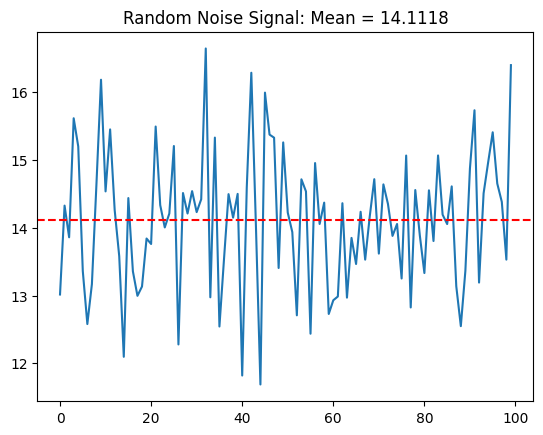

In [25]:
# generate random noise signal
N = 100
noise = np.random.normal(size=N)
signal = 14.0 + noise

plt.plot(signal)
plt.title(f'Random Noise Signal: Mean = {signal.mean():.4f}')
plt.axhline(y = signal.mean(), color = 'red', linestyle = '--')
plt.show()

Text(0.5, 1.0, 'Average Filter')

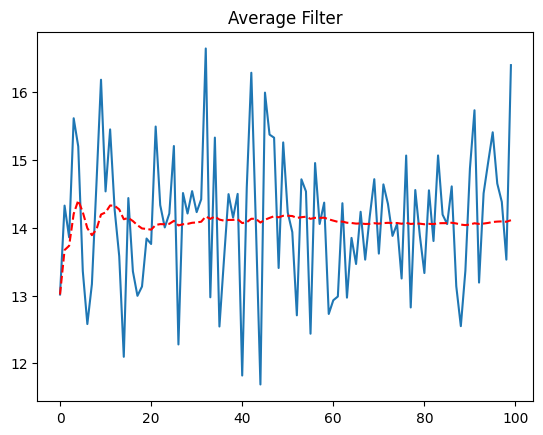

In [26]:
# average filter
def avg_filter(k, signal, mean, N, mean_states):
    if k > N:
        return

    alpha = (k-1)/k
    mean = (1-alpha)*signal[k-1] + alpha*mean
    mean_states.append(mean)
    avg_filter(k+1, signal, mean, N, mean_states)

mean_states = []
avg_filter(1, signal, 0, N, mean_states)

plt.plot(signal)
plt.plot(mean_states, linestyle = '--', color= 'red')
plt.title('Average Filter')

## 2. Moving Average Filter

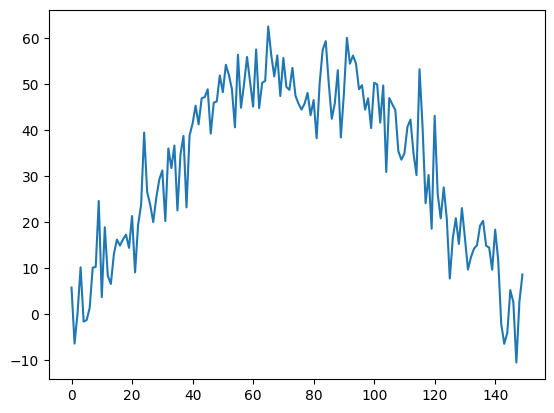

In [61]:
num = 50
ascend = np.linspace(0, 50, num) + np.random.exponential(5, num) - np.random.exponential(5, num)
cruise = np.random.normal(50, 5, num)
descend = np.linspace(50, 0, num) + np.random.exponential(5, num) - np.random.exponential(5, num)
signal = np.concat([ascend, cruise, descend])
N = len(signal)
plt.plot(signal)

Text(0.5, 1.0, 'Moving Average Filter')

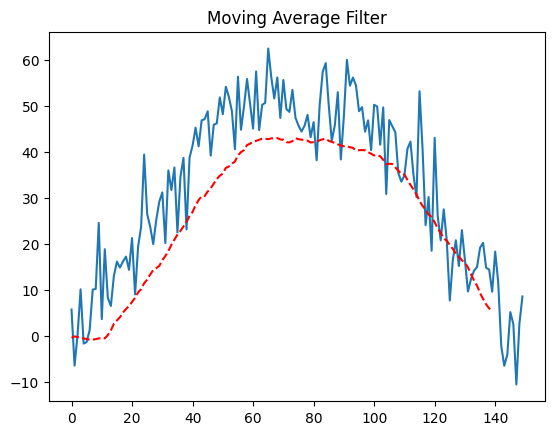

In [66]:
# moving average filter
def mov_avg_filter(k, signal, mean, N, mean_states, n):

    if k > N:
        return
    mean = mean + (signal[k-1] - signal[k-n-1])/n
    mean_states.append(mean)
    mov_avg_filter(k+1, signal, mean, N, mean_states, n)

mean_states = []
n = 30
mov_avg_filter(11, signal, 0, N, mean_states, n)
plt.plot(signal)
plt.plot(mean_states, linestyle = '--', color= 'red')
plt.title('Moving Average Filter')

## 3. Low Pass Filter

Text(0.5, 1.0, 'Low Pass Filter')

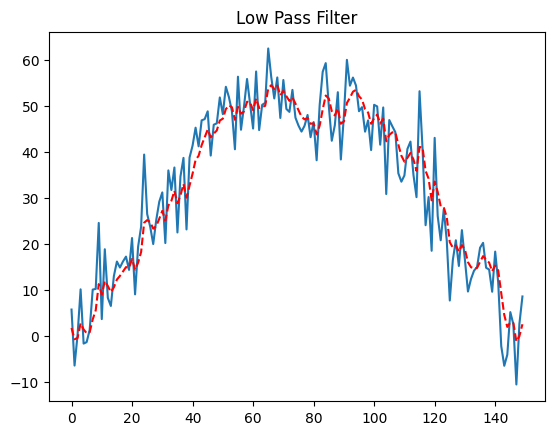

In [70]:
# low pass filter
alpha = 0.7
def low_pass_filter(k, signal, mean, N, mean_states):
    if k > N:
        return

    mean = (1-alpha)*signal[k-1] + alpha*mean
    mean_states.append(mean)
    low_pass_filter(k+1, signal, mean, N, mean_states)

mean_states = []
low_pass_filter(1, signal, 0, N, mean_states)
plt.plot(signal)
plt.plot(mean_states, linestyle = '--', color= 'red')
plt.title('Low Pass Filter')

## 4. Kalman Filter

### 4.1 1-D Kalman Filter

In [12]:
# get data
CURR_DIR = os.getcwd()
DATA_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
os.makedirs(os.path.join(DATA_DIR, 'data'), exist_ok=True)

os.chdir(os.path.join(DATA_DIR, 'data'))

if not os.path.exists('ETDataset'):
    print('Cloning ETTDataset...')
    !git clone git@github.com:zhouhaoyi/ETDataset.git

df = pd.read_csv('ETDataset/ETT-small/ETTh1.csv')

os.chdir(CURR_DIR)

In [13]:
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


Dataset contains 2 year * 365 days * 24 hours = 17520 data point. Each data point consists of 8 features, including the date of the point, the predictive value "**oil temperature**", and 6 different types of external power load features.

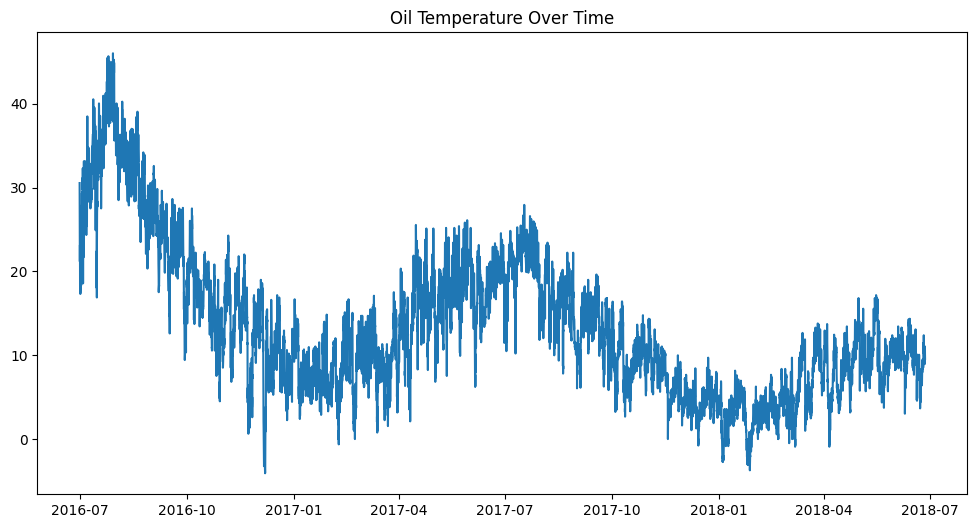

In [14]:
# visualize
df.date = pd.to_datetime(df.date)

plt.figure(figsize=(12, 6))
plt.plot(df.date.values, df.OT.values)
plt.title('Oil Temperature Over Time')
plt.show()

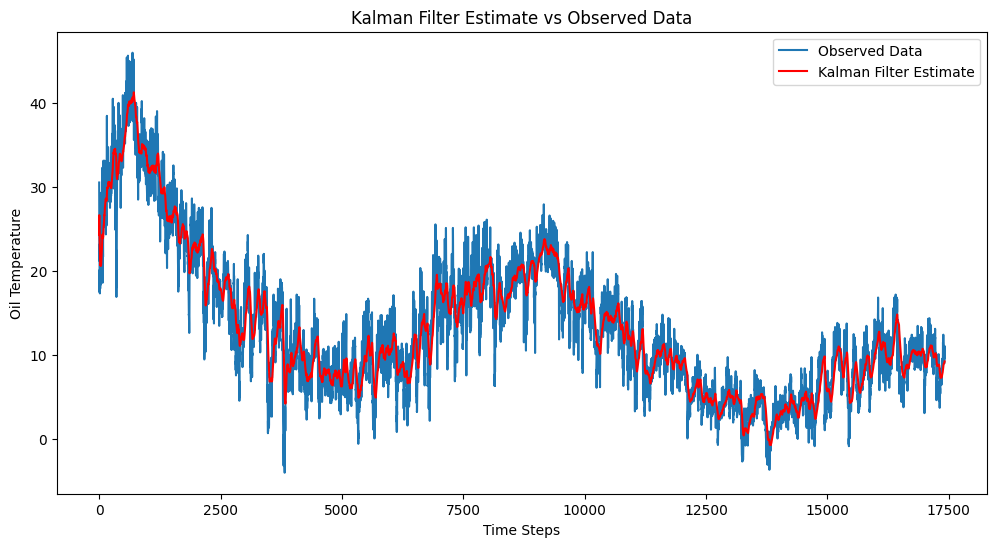

In [25]:
data = df.OT.values
init_data = data[:100]

# Number of time steps
n = len(data)

# Kalman Filter Initialization
x_est = np.zeros(n)      # Estimated state
x_pred = np.zeros(n)     # Predicted state
K = np.zeros(n)          # Kalman Gain

A = 1.0
H = 1.0

x_est[0] = np.mean(init_data)     # Initial estimate
P = np.var(init_data)               # Initial estimate covariance

Q = 0.01                               # Process variance
R = np.var(init_data)               # Measurement variance

threshold = 3000

# Kalman Filter Loop
for t in range(1, n):
    # Prediction step
    x_pred[t] = A * x_est[t-1]
    P_pred = A * P * A + Q

    # Kalman Gain
    K[t] = P_pred * H / (H * P_pred * H + R)

    # Update step
    x_est[t] = x_pred[t] + K[t] * (data[t] - H * x_pred[t])
    P = (1 - K[t] * H) * P_pred

# plot
plt.figure(figsize=(12, 6))
plt.plot(data, label='Observed Data')
plt.plot(x_est, label='Kalman Filter Estimate', color='red')
plt.title('Kalman Filter Estimate vs Observed Data')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.legend()
plt.show()

### 4.2 1-D Kalman Filter (Estimating Velocity from Position)

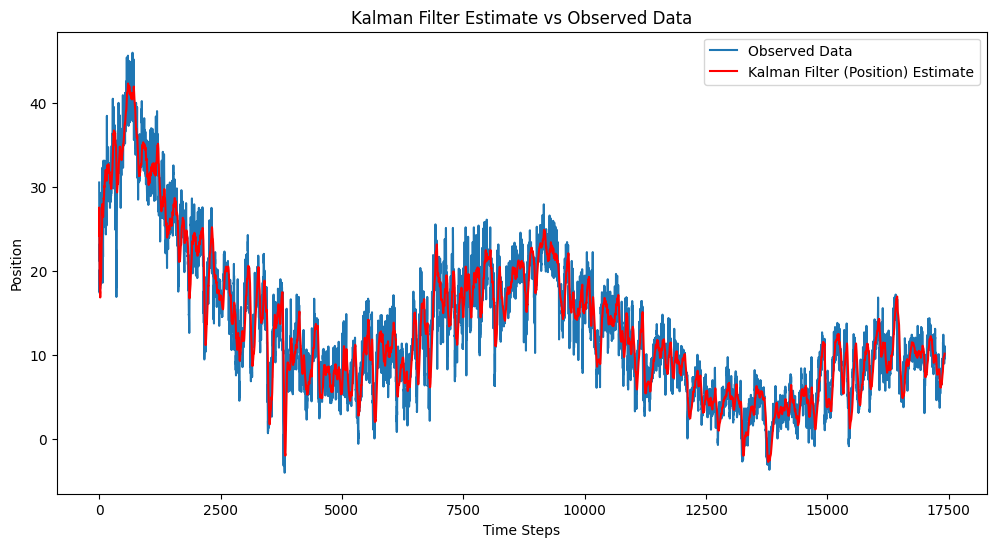

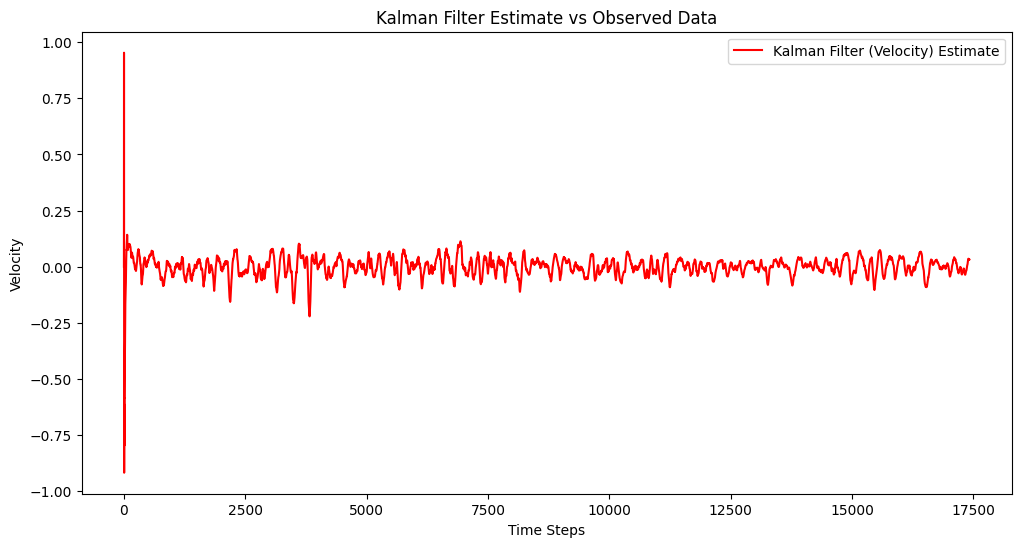

In [28]:
# Number of time steps
n = len(data)

# Kalman Filter Initialization
x_est = np.zeros((n,2))      # Estimated state
x_pred = np.zeros((n,2))     # Predicted state

dt = 1
A = np.array([[1.0, dt],
              [0, 1]])
H = np.array([[1.0, 0]])

# Initial estimate
x_est[0][0] = np.median(init_data)
x_est[0][1] = 0
P = np.array([[np.var(init_data), 0],
              [0, 10]])

Q = np.array([[0.001, 0],
              [0, 0.00001]])              # Process variance
R = np.var(init_data)               # Measurement variance


# Kalman Filter Loop
for t in range(1, n):
    # Prediction step
    x_pred[t] = A @ x_est[t-1]
    P_pred = A @ P @ A.T + Q

    # Kalman Gain
    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)

    # Update step
    x_est[t] = x_pred[t] + K @ (data[t] - H @ x_pred[t])
    P = P_pred - K @ H @ P_pred

# plot
plt.figure(figsize=(12, 6))
plt.plot(data, label='Observed Data')
plt.plot(x_est[:, 0], label='Kalman Filter (Position) Estimate', color='red')
plt.title('Kalman Filter Estimate vs Observed Data')
plt.xlabel('Time Steps')
plt.ylabel('Position')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(x_est[:, 1], label='Kalman Filter (Velocity) Estimate', color='red')
plt.title('Kalman Filter Estimate vs Observed Data')
plt.xlabel('Time Steps')
plt.ylabel('Velocity')
plt.legend()
plt.show()